This notebook is part of the Modern Deep Learning Foundations course (Lessons 12–14). It explores how different design choices affect model performance in deep learning.
You’ll experiment with four important topics that every practitioner should know:

* Initialization – how different ways of setting the initial weights (like HeNormal or GlorotUniform) change how fast and how well a network learns.

* Normalization - how methods like Batch Normalization and Layer Normalization help stabilize and speed up training.

* Data Augmentation - how simple image transformations (flip, rotation, zoom) can improve model generalization when we have limited data.

* Optimization - how advanced optimizers such as Adam and AdamW influence convergence and model quality.

All examples use the Fashion-MNIST dataset and run for 30 epochs to make the differences between methods easy to observe.

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np, matplotlib.pyplot as plt

print("TensorFlow version:", tf.__version__)


def plot_history(histories, title, metric="val_accuracy"):
    plt.figure(figsize=(8,5))
    for name,h in histories.items():
        plt.plot(h.history[metric], label=name, linewidth=2)
    plt.title(title, fontsize=13)
    plt.xlabel("Epoch", fontsize=11)
    plt.ylabel(metric.replace("_"," ").title(), fontsize=11)
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()

TensorFlow version: 2.19.0


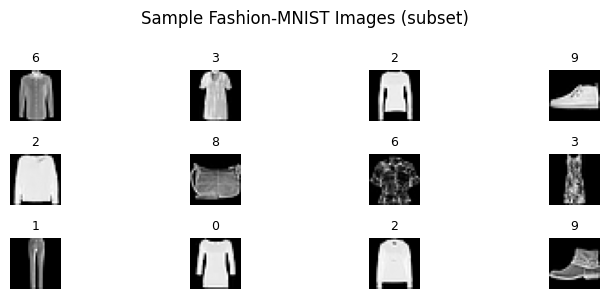

In [ ]:
# ================================================================
# DATASET
# ================================================================
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()
x_train, x_test = x_train[..., None]/255.0, x_test[..., None]/255.0

# smaller training subset (to make differences more visible)
x_train_full, y_train_full = x_train, y_train # Keep full dataset for validation split
x_train, y_train = x_train_full[:20000], y_train_full[:20000]

val_size = 3000
x_val, y_val = x_train_full[:val_size], y_train_full[:val_size] # Create validation set from full dataset
x_train, y_train = x_train_full[val_size:20000], y_train_full[val_size:20000] # Adjust training set slice


BATCH = 128
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(2048).batch(BATCH)
val_ds   = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(BATCH)

def show_images(images, labels, title=""):
    fig, axs = plt.subplots(3,4,figsize=(8,3))
    axs = axs.flatten()
    for i in range(12):
        axs[i].imshow(images[i].squeeze(), cmap="gray")
        axs[i].set_title(str(labels[i]), fontsize=9)
        axs[i].axis("off")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

show_images(x_train, y_train, "Sample Fashion-MNIST Images (subset)")

# SECTION 1 - Initialization
* Explore how the choice of initializer influences training stability and convergence speed. Below, a dictionary named initializers defines several options used when building the model.
* In the build_mlp(init) function, find this line: `layers.Dense(128, activation="elu", kernel_initializer=init),` change the number 128 to 64 and rerun the entire cell. Observe how reducing the hidden layer size changes the model’s performance and convergence curves.



In [ ]:
initializers = {
    "HeNormal": keras.initializers.HeNormal(),
    "GlorotUniform": keras.initializers.GlorotUniform(),
    "Zeros": keras.initializers.Zeros(),
    "Constant(0.1)": keras.initializers.Constant(0.1),
    "RandomNormal": keras.initializers.RandomNormal(mean=0.0, stddev=0.05),
}

def build_mlp(init):
    return keras.Sequential([
        layers.Flatten(input_shape=(28,28,1)),
        layers.Dense(256, activation="elu", kernel_initializer=init),
        layers.Dense(128, activation="elu", kernel_initializer=init),
        layers.Dense(10, activation="softmax", kernel_initializer=init)
    ])

hist_init = {}
for name, init in initializers.items():
    print(f"\nTraining with {name}")
    model = build_mlp(init)
    model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    h = model.fit(train_ds, validation_data=val_ds, epochs=30, verbose=0)
    hist_init[name] = h

plot_history(hist_init, "Initialization Comparison (ELU, 30 epochs)")

# SECTION 2 - Normalization

Complete the normalization logic: Inside the function, scroll to the SECOND convolution block, after the first MaxPooling2D, below the line:
`x = layers.Conv2D(64,3,padding="same",use_bias=(norm is None))(x)`
add these two lines:
        
```
 if norm=="batch":
             x = layers.BatchNormalization()(x)
         if norm=="layer":
             x = layers.LayerNormalization(axis=[1,2,3])(x)```


In [ ]:
def cnn_block(norm=None):
    inputs = keras.Input(shape=(28,28,1))
    x = layers.Conv2D(32,3,padding="same",use_bias=(norm is None))(inputs)
    if norm=="batch": x = layers.BatchNormalization()(x)
    if norm=="layer": x = layers.LayerNormalization(axis=[1,2,3])(x)
    x = layers.ELU()(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64,3,padding="same",use_bias=(norm is None))(x)
    if norm=="batch": x = ???
    if norm=="layer": x = ???
    x = layers.ELU()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation="elu")(x)
    outputs = layers.Dense(10, activation="softmax")(x)
    return keras.Model(inputs, outputs)

modes = {"None":None,"BatchNorm":"batch","LayerNorm":"layer"}
hist_norm = {}
for n, tag in modes.items():
    print(f"\nTraining with {n}")
    model = cnn_block(tag)
    model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    h = model.fit(train_ds, validation_data=val_ds, epochs=30, verbose=0)
    hist_norm[n] = h

plot_history(hist_norm, "Normalization Comparison (30 epochs)")

# SECTION 3 - Data Augmentation (training a subset)

In this exercise, you’ll observe how simple image transformations  (flip, rotation, zoom) improve model generalization when training on a small dataset.
* Locate the augmentation definition, find this code block:
```
      data_aug = keras.Sequential([
             layers.RandomFlip("horizontal"),
             layers.RandomRotation(0.04),
             layers.RandomZoom(0.05)
         ])
```

* Modify one transformation- try changing the rotation range to make the augmentation stronger: `layers.RandomRotation(0.10)` or increase zoom slightly: `layers.RandomZoom(0.10)`

* Run the following line to see the new augmented samples:         `visualize_aug(x_train[:16])`. Make sure the augmented images still look realistic.

* Inspect the `cnn_aug()` function: This function applies augmentation only when: `flag=True`, so that the model can be trained both with and without augmented data.

In [ ]:
data_aug = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.04),  # Smaller rotation
    layers.RandomZoom(0.05)       # Smaller zoom
])

def visualize_aug(x):
    fig,axs=plt.subplots(2,8,figsize=(12,3))
    for i,ax in enumerate(axs.flatten()):
        ax.imshow(data_aug(x[i:i+1],training=True)[0].numpy().squeeze(),cmap="gray")
        ax.axis("off")
    plt.suptitle("Augmented Samples")
    plt.show()

visualize_aug(x_train[:16])

def cnn_aug(flag=False):
    inputs = keras.Input(shape=(28,28,1))
    x = data_aug(inputs) if flag else inputs
    x = layers.Conv2D(32,3,padding="same",activation="elu")(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64,3,padding="same",activation="elu")(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128,activation="elu")(x)
    outputs = layers.Dense(10,activation="softmax")(x)
    return keras.Model(inputs,outputs)

# use smaller portion to make augmentation impact visible
train_small = train_ds.take(80)
val_small   = val_ds.take(60)

hist_aug = {}
for flag in [False,True]:
    tag = "WithAug" if flag else "NoAug"
    print(f"\nTraining {tag} on smaller subset")
    m = cnn_aug(flag)
    m.compile(optimizer="adam",loss="sparse_categorical_crossentropy",metrics=["accuracy"])
    h = m.fit(train_small,validation_data=val_small,epochs=30,verbose=0)
    hist_aug[tag] = h

plot_history(hist_aug, "Effect of Data Augmentation (30 epochs, small subset)")

# SECTION 4 - Advanced Optimization
* Create two new optimizers for comparison, Add these lines right below:

`adam_fast = keras.optimizers.Adam(learning_rate=5e-3)`

`adam_slow = keras.optimizers.Adam(learning_rate=1e-4)`

* Update the dictionary:
```
        optimizers = {
             "Adam_fast": adam_fast,
             "Adam_normal": adam_opt,
             "Adam_slow": adam_slow
         }
```



In [ ]:
def build_small_cnn():
    return keras.Sequential([
        layers.Conv2D(32, 3, padding="same", activation="elu", input_shape=(28, 28, 1)),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, padding="same", activation="elu"),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(128, activation="elu"),
        layers.Dense(10, activation="softmax")
    ])

adam_fast = ???    # very fast learning
adam_mid  = keras.optimizers.Adam(learning_rate=1e-3)    # baseline
adam_slow = ???    # very slow learning

# Add AdamW for comparison (includes weight decay regularization)
adamw_opt = keras.optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-4)

optimizers = {
    "Adam_fast (η=5e-3)": adam_fast,
    "Adam_mid (η=1e-3)": adam_mid,
    "Adam_slow (η=1e-4)": adam_slow,
    "AdamW (η=1e-3, wd=1e-4)": adamw_opt
}

hist_opt = {}

for name, opt in optimizers.items():
    print(f"\nTraining with {name}")
    model = build_small_cnn()
    model.compile(optimizer=opt, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    h = model.fit(train_ds.take(150), validation_data=val_ds.take(100), epochs=30, verbose=0)
    hist_opt[name] = h


plot_history(hist_opt, "Optimizer & Learning Rate Comparison (Adam vs AdamW, 30 epochs)")